In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [10]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./famine_data/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [14]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

In [7]:
# need end to be low-dimensional
# 128 reduced error a lot from 4096
# try maybe even 32/64 next time
model_ft.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=256, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=256, out_features=3, bias=True),
)

In [8]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

In [15]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [10]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [11]:
num_epochs = 5

In [13]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 0.8711 Acc: 0.6898
valid Loss: 0.8074 Acc: 0.7214

Epoch 1/4
----------
train Loss: 0.7968 Acc: 0.7031
valid Loss: 0.7186 Acc: 0.7268

Epoch 2/4
----------
train Loss: 0.7493 Acc: 0.7018
valid Loss: 0.6847 Acc: 0.7295

Epoch 3/4
----------
train Loss: 0.7231 Acc: 0.7081
valid Loss: 0.6684 Acc: 0.7322

Epoch 4/4
----------
train Loss: 0.7009 Acc: 0.7118
valid Loss: 0.6637 Acc: 0.7174

Training complete in 2m 44s
Best val Acc: 0.732167


In [16]:
import pandas as pd

In [17]:
im_to_const = pd.read_csv('famine_data/all_ims_guide.csv')

In [18]:
im_to_const.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,images,clust_num,nightlight_bin
0,-16.941666,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.941666_35.208332_0.png,0,1
1,-16.950000,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.95_35.208332_0.png,0,1
2,-16.958333,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.958333_35.208332_0.png,0,1
3,-16.966666,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.966666_35.208332_0.png,0,1
4,-16.975000,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.975_35.208332_0.png,0,1


In [19]:
data_dir = './famine_data/'

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model_ft.eval()   # Set model to evaluate mode

running_loss = 0.0
running_corrects = 0
total = 0

# Iterate over data.
for inputs, labels in dataloaders_dict['train']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
    total += len(preds)
    if total == 1000:
        break

In [ ]:
running_corrects.double()/total

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

def filename_to_im_tensor(file):
    im = plt.imread(file)[:,:,:3]
    im = (im*256).astype(np.uint8)
    im = Image.fromarray(im)
    im = data_transforms['train'](im)
    return im[None].to(device)

In [19]:
model_ft.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=256, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=256, out_features=3, bias=True)
)

In [20]:
ripped = model_ft.classifier

In [21]:
del ripped[6]
del ripped[5]
del ripped[4]
ripped

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=256, bias=True)
)

In [22]:
im_to_const.shape

(74052, 9)

In [23]:
feats = np.zeros((74052,256))

In [24]:
model_ft.eval()
for i, im_name in enumerate(im_to_const['images']):
    image = filename_to_im_tensor('famine_data/ims_renamed/{}'.format(im_name))
    res = np.array(model_ft(image).cpu().detach().numpy().tolist()[0])
    feats[i,:] += res
    if i % 100 == 0:
        print(i, end=', ')

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800,

In [20]:
feats = np.load('forward_feats.npy')

In [21]:
ims = os.listdir('famine_data/ims')

In [22]:
len(ims)

30477

In [23]:
df_im_raw = pd.DataFrame.from_dict({'images': ims}); df_im_raw.head()

,images
0,-14.416666000000001_34.466666.png
1,-14.075_35.174999.png
2,-14.233332999999998_34.408332.png
3,-13.958332999999998_33.916666.png
4,-15.708332999999998_35.283332.png


In [24]:
im_to_const.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,images,clust_num,nightlight_bin
0,-16.941666,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.941666_35.208332_0.png,0,1
1,-16.950000,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.95_35.208332_0.png,0,1
2,-16.958333,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.958333_35.208332_0.png,0,1
3,-16.966666,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.966666_35.208332_0.png,0,1
4,-16.975000,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.975_35.208332_0.png,0,1


In [25]:
def parse_im(x):
    x = x.split('_')
    return x[0] + '_' + x[1] + '.png'

In [26]:
im_to_const['im_og'] = im_to_const['images'].apply(parse_im)

In [27]:
im_to_const.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,images,clust_num,nightlight_bin,im_og
0,-16.941666,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.941666_35.208332_0.png,0,1,-16.941666_35.208332.png
1,-16.950000,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.95_35.208332_0.png,0,1,-16.95_35.208332.png
2,-16.958333,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.958333_35.208332_0.png,0,1,-16.958333_35.208332.png
3,-16.966666,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.966666_35.208332_0.png,0,1,-16.966666_35.208332.png
4,-16.975000,35.208332,-16.9855,35.2499,0.036855,1.951277,-16.975_35.208332_0.png,0,1,-16.975_35.208332.png


In [28]:
im_to_const.shape

(74052, 10)

In [29]:
df_im_raw['feat_index'] = np.arange(len(df_im_raw))

In [30]:
im_to_const = pd.merge(left=im_to_const, right=df_im_raw, left_on='im_og', right_on='images')

In [31]:
im_to_const.shape

(74052, 12)

In [32]:
im_to_const.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,images_x,clust_num,nightlight_bin,im_og,images_y,feat_index
0,-16.941666,35.208332,-16.985500,35.249900,0.036855,1.951277,-16.941666_35.208332_0.png,0,1,-16.941666_35.208332.png,-16.941666_35.208332.png,6754
1,-16.941666,35.208332,-16.952974,35.203069,0.502674,2.171500,-16.941666_35.208332_1.png,1,1,-16.941666_35.208332.png,-16.941666_35.208332.png,6754
2,-16.941666,35.208332,-16.934744,35.248479,0.616477,12.299129,-16.941666_35.208332_3.png,3,1,-16.941666_35.208332.png,-16.941666_35.208332.png,6754
3,-16.950000,35.208332,-16.985500,35.249900,0.036855,1.951277,-16.95_35.208332_0.png,0,1,-16.95_35.208332.png,-16.95_35.208332.png,298
4,-16.950000,35.208332,-16.952974,35.203069,0.502674,2.171500,-16.95_35.208332_1.png,1,1,-16.95_35.208332.png,-16.95_35.208332.png,298


In [33]:
group = im_to_const.groupby(['clust_lat', 'clust_lon'])

In [34]:
num_clusts = len(group); num_clusts

928

In [35]:
x = np.zeros((num_clusts, 4096))
y = []

In [60]:
for i, g in enumerate(group):
    lat, long = g[0]
    im_sub = im_to_const[(im_to_const['clust_lat'] == lat) & (im_to_const['clust_lon'] == long)].reset_index(drop=True)
    agg_feats = np.zeros((len(im_sub), 4096))
    for j, d in im_sub.iterrows():
        agg_feats[j,:] = feats[d.feat_index]
    agg_feats = agg_feats.mean(axis=0)
    
    x[i,:] = agg_feats
    y.append(g[1]['consumption'].values[0])

In [61]:
y = np.array(y)

In [62]:
x.shape

(928, 4096)

In [132]:
import numpy as np
import pandas as pd
import random
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
import seaborn as sns

############################
######### Figure 3 #########
############################


def predict_consumption(
    X, y, dimension=None, k=5, k_inner=5, points=10,
        alpha_low=1, alpha_high=5, margin=0.25):
    """
    Plots predicted consumption
    """
    X = reduce_dimension(X, dimension)
    y_hat, r2 = run_cv(X, y, k, k_inner, points, alpha_low, alpha_high)
    return X, y, y_hat, r2


def plot_predictions(country, y, y_hat, r2, margin):
    """
    Plots consumption predictions vs. true values.
    """
    slope, intercept, ymin, ymax, xmin, xmax = compute_plot_params(
        y, y_hat, margin)
    sns.set_style('white')
    plt.figure()
    plt.axis('equal')
    plt.scatter(y, y_hat, edgecolor='k', color='lightblue', s=20, marker='o')
    x_trend = np.array([xmin, xmax]) * 1.5
    y_trend = slope * x_trend + intercept
    plt.plot(x_trend, y_trend, 'b-', linewidth=2,
             color=sns.xkcd_rgb['french blue'])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('Log consumption expenditures', fontsize=14)
    plt.ylabel('Model predictions', fontsize=14)
    plt.title(country.capitalize() + ': $r^2 = {0:.2f}$'.format(r2))
    plt.show()


def compute_plot_params(y, y_hat, margin):
    """
    Computes parameters for plotting consumption predictions vs. true values.
    """
    slope, intercept, _, _, _ = stats.linregress(y, y_hat)
    ymin = min(y_hat) - margin
    ymax = max(y_hat) + margin
    xmin = min(y) - margin
    xmax = max(y) + margin
    return slope, intercept, ymin, ymax, xmin, xmax

############################
######## Figure 4ab ########
############################


def compare_models(
    country_path, survey, percentiles, dimension, k, k_inner, trials,
        poverty_line, multiples):
    """
    Evaluates and plots comparison of transfer learning and nightlight models.
    """
    r2s, r2s_nl = evaluate_percentiles(
        country_path, survey, percentiles, dimension, k, k_inner, trials)
    if survey == 'lsms':
        X, X_nl, y = load_and_reduce_country_by_percentile(
            country_path, survey, 1.0, dimension)
        fractions = compute_fractions(poverty_line, multiples, y)
        plot_percentiles_lsms(percentiles, multiples, r2s, r2s_nl, fractions)
    elif survey == 'dhs':
        plot_percentiles_dhs(percentiles, r2s, r2s_nl)


def load_and_reduce_country_by_percentile(
        country_path, survey, percentile, dimension):
    """
    Loads data for one country up to a certain percentile.
    """
    if survey == 'lsms':
        X, X_nl, y = load_country_lsms(country_path)
    elif survey == 'dhs':
        X, X_nl, y = load_country_dhs(country_path)
    X, X_nl, y = threshold_by_percentile(X, X_nl, y, percentile)
    X = reduce_dimension(X, dimension)
    return X, X_nl, y


def threshold_by_percentile(X, X_nl, y, percentile):
    """
    Threshold data by output percentile.
    """
    threshold = np.percentile(y, q=100*percentile)
    X = X[y <= threshold]
    X_nl = X_nl[y <= threshold]
    y = y[y <= threshold]
    return X, X_nl, y


def evaluate_percentiles(
        country_path, survey, percentiles, dimension, k, k_inner, trials):
    """
    Evaluate transfer learning and nightlight models for each percentile.
    """
    r2s = np.zeros((len(percentiles), trials))
    r2s_nl = np.zeros((len(percentiles), trials))
    for idx, percentile in enumerate(percentiles):
        for trial in xrange(trials):
            X, X_nl, y = load_and_reduce_country_by_percentile(
                country_path, survey, percentile, dimension)
            _, r2 = run_cv(
                X, y, k, k_inner, points=10, alpha_low=0, alpha_high=3,
                randomize=False)
            r2_nl = run_cv_ols(X_nl, y, k)
            r2s[idx, trial] = r2
            r2s_nl[idx, trial] = r2_nl
    r2s = r2s.mean(axis=1)
    r2s_nl = r2s_nl.mean(axis=1)
    return r2s, r2s_nl


def run_cv_ols(X, y, k):
    """
    Runs OLS in cross-validation to compute r-squared.
    """
    r2s = np.zeros((k,))
    kf = cross_validation.KFold(n=y.size, n_folds=k, shuffle=True)
    fold = 0
    for train_idx, test_idx in kf:
        r2s, fold = evaluate_fold_ols(X, y, train_idx, test_idx, r2s, fold)
    return r2s.mean()


def evaluate_fold_ols(X, y, train_idx, test_idx, r2s, fold):
    """
    Evaluates one fold of outer CV using OLS.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ols(X_train, y_train, X_test)
    r2 = stats.pearsonr(y_test, y_test_hat)[0] ** 2
    if np.isnan(r2):
        r2 = 0
    r2s[fold] = r2
    return r2s, fold + 1


def train_and_predict_ols(X_train, y_train, X_test):
    """
    Trains OLS model and predicts test set.
    """
    ols = linear_model.LinearRegression()
    ols.fit(X_train, y_train)
    y_hat = ols.predict(X_test)
    return y_hat


def compute_fractions(poverty_line, multiples, y):
    """
    Computes the fraction of clusters below each multiple of the poverty line.
    """
    fractions = np.zeros((len(multiples),))
    for idx, multiple in enumerate(multiples):
        fractions[idx] = (
            np.exp(y) <= poverty_line * multiple).sum() / float(y.size)
    return fractions


def plot_percentiles_lsms(percentiles, multiples, r2s, r2s_nl, fractions):
    """
    Plots transfer learning model vs. nightlights model at each percentile.
    """
    sns.set_style('white')
    plt.figure(figsize=(6, 6))
    lines = []
    percentiles = [100 * x for x in percentiles]
    for idx, multiple in enumerate(multiples):
        lines.append(
            plt.axvline(
                100 * fractions[idx], color='r', linestyle='dashed',
                linewidth=3.0 / (idx + 1),
                label=str(multiple) + 'x poverty line'))
    line_legend = plt.legend(
        handles=lines, title='Poverty line multiples:', loc='upper right',
        bbox_to_anchor=(0.5, 1), fontsize=10)
    plt.gca().add_artist(line_legend)
    curve1, = plt.plot(percentiles, r2s, label='Transfer learning')
    curve2, = plt.plot(percentiles, r2s_nl, label='Nightlights')
    plt.legend(
        handles=[curve1, curve2], loc='upper right',
        bbox_to_anchor=(0.5, 0.65))
    plt.xlabel('Poorest percent of clusters used', fontsize=14)
    plt.ylabel('$r^2$', fontsize=18)
    plt.show()


def plot_percentiles_dhs(percentiles, r2s, r2s_nl):
    """
    Plots transfer learning model vs. nightlights model at each
    """
    sns.set_style('white')
    plt.figure(figsize=(6, 6))
    percentiles = [100 * x for x in percentiles]
    plt.plot(percentiles, r2s)
    plt.plot(percentiles, r2s_nl)
    plt.legend(['Transfer learning', 'Nightlights'], loc='upper center')
    plt.xlabel('Poorest percent of clusters used', fontsize=14)
    plt.ylabel('$r^2$', fontsize=18)
    plt.show()

############################
######## Figure 4cd ########
############################


def run_randomization_test(
    country_names, country_paths, survey, dimension, k, k_inner, points,
        alpha_low, alpha_high, trials):
    """
    Runs randomization test for a set of countries.
    """
    data = load_data(country_paths, survey, dimension)
    true_r2s = compute_true_r2s(
        data, k, k_inner, points, alpha_low, alpha_high)
    shuffled_r2s = compute_shuffled_r2s(
        data, k, k_inner, points, alpha_low, alpha_high, trials)
    plot_shuffled_distributions(country_names, survey, shuffled_r2s, true_r2s)


def compute_true_r2s(data, k, k_inner, points, alpha_low, alpha_high):
    """
    Uses data to compute true model r2s.
    """
    true_r2s = []
    for (X, y) in data:
        _, r2 = run_cv(X, y, k, k_inner, points, alpha_low, alpha_high)
        true_r2s.append(r2)
    return true_r2s


def compute_shuffled_r2s(
        data, k, k_inner, points, alpha_low, alpha_high, trials):
    """
    Uses data to compute shuffled model r2s.
    """
    shuffled_r2s = np.zeros((len(data), trials))
    for data_idx, (X, y) in enumerate(data):
        for trial in range(trials):
            _, shuffled_r2s[data_idx, trial] = run_cv(
                X, y, k, k_inner, points, alpha_low, alpha_high,
                randomize=True)
    return shuffled_r2s


def plot_shuffled_distributions(country_names, survey, shuffled_r2s, true_r2s):
    """
    Plots shuffled r2 distributions vs. true model r2s.
    """
    colors = sns.color_palette('husl', len(country_names))
    sns.set_style('white')
    plt.figure(figsize=(8, 8))
    frame = plt.gca()
    for i in xrange(len(country_names)):
        plt.axvline(
            true_r2s[i], color=colors[i], linestyle='dashed', linewidth=2,
            label=country_names[i].capitalize() + ': $r^2={0:.2f}$'.format(
                true_r2s[i]))
    plt.legend(
        title='True {} Models:'.format(survey.upper()), loc='lower right',
        bbox_to_anchor=(0.6, 0.45), fontsize=12)
    for i in xrange(len(country_names)):
        sns.kdeplot(shuffled_r2s[i, :], shade=True, color=colors[i])
    plt.xlim((0, max(true_r2s) + 0.05))
    plt.xlabel('$r^2$', fontsize=18)
    plt.ylabel('Randomized $r^2$ distribution', fontsize=14)
    frame.yaxis.set_ticklabels([])
    plt.show()

############################
######### Figure 5 #########
############################


def evaluate_models(
    country_names, country_paths, survey, dimension, k, trials, points,
        alpha_low, alpha_high, cmap='Greens'):
    """
    Evaluates in- and out-of-country performance for models trained on set of
    countries given.
    """
    n = len(country_names)
    performance_matrix = np.zeros((trials, n, n))
    data = load_data(country_paths, survey, dimension=None)
    for trial in xrange(trials):
        for in_idx in xrange(n):
            performance_matrix[trial, :, in_idx] = compute_column(
                country_names[in_idx], data, in_idx, dimension, k, points,
                alpha_low, alpha_high)
    performance_matrix = performance_matrix.mean(axis=0)
    plot_model_performance(performance_matrix, country_names, cmap)
    return np.around(performance_matrix, decimals=2)


def compute_column(
    country_name, data, in_idx, dimension, k, points, alpha_low,
        alpha_high):
    """
    Evaluates in- and out-of-country performance for model trained on one
    country.
    """
    in_data = data[in_idx]
    out_data = list(data)
    out_data.pop(in_idx)
    if country_name == 'pooled':
        r2s_in, r2s_out = evaluate_pooled_r2s(
            out_data, dimension, k, points, alpha_low, alpha_high)
    else:
        r2s_in, r2s_out = evaluate_model_r2s(
            in_data, out_data, dimension, k, points, alpha_low, alpha_high)
    max_idx = np.argmax(r2s_in)
    r2s = list(r2s_out[:, max_idx])
    r2s.insert(in_idx, r2s_in[max_idx])
    r2s.reverse()
    r2s = np.array(r2s)
    return r2s


def evaluate_pooled_r2s(all_data, dimension, k, points, alpha_low, alpha_high):
    """
    Evaluates in- and out-of-country r2s for the pooled model.
    """
    X_all_full, y_all = [list(data) for data in zip(*all_data)]
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s_in = np.zeros((k, points))
    r2s_out = np.zeros((len(all_data), k, points))
    kf = []
    for i in xrange(len(X_all_full)):
        kf.append(list(cross_validation.KFold(
            n=all_data[i][1].size, n_folds=k, shuffle=True)))
    for fold in xrange(k):
        X_train, X_test, y_train, y_test = split_pooled_data(
            kf, fold, X_all_full, y_all)
        X_train, X_test, X_all = reduce_and_scale_features(
            X_train, X_test, X_all_full, dimension)
        r2s_in, r2s_out = evaluate_alphas(
            X_train, X_test, X_all, y_train, y_test, y_all, r2s_in, r2s_out,
            fold, alphas)
    return r2s_in.mean(axis=0), r2s_out.mean(axis=1)


def split_pooled_data(kf, fold, X_all_full, y_all):
    """
    Splits pooled training and test data for each fold.
    """
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in xrange(len(kf)):
        train_ind = kf[i][fold][0]
        test_ind = kf[i][fold][1]
        X_train.append(X_all_full[i][train_ind])
        X_test.append(X_all_full[i][test_ind])
        y_train.append(y_all[i][train_ind])
        y_test.append(y_all[i][test_ind])
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, X_test, y_train, y_test


def evaluate_model_r2s(
        in_data, out_data, dimension, k, points, alpha_low, alpha_high):
    """
    Evaluates in- and out-of-country r2s.
    """
    X, y = in_data
    X_out_full, y_out = [list(data) for data in zip(*out_data)]
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s_in = np.zeros((k, points))
    r2s_out = np.zeros((len(out_data), k, points))
    kf = cross_validation.KFold(n=in_data[1].size, n_folds=k, shuffle=True)
    fold = 0
    for train_ind, test_ind in kf:
        X_train, X_test = X[train_ind], X[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]
        X_train, X_test, X_out = reduce_and_scale_features(
            X_train, X_test, X_out_full, dimension)
        r2s_in, r2s_out = evaluate_alphas(
            X_train, X_test, X_out, y_train, y_test, y_out, r2s_in, r2s_out,
            fold, alphas)
        fold += 1
    return r2s_in.mean(axis=0), r2s_out.mean(axis=1)


def evaluate_alphas(
    X_train, X_test, X_out, y_train, y_test, y_out, r2s_in, r2s_out, fold,
        alphas):
    """
    Computes r2 for different regularization constants.
    """
    for idx, alpha in enumerate(alphas):
        ridge = linear_model.Ridge(alpha=alpha)
        ridge.fit(X_train.astype(np.float), y_train.astype(np.float))
        r2s_in[fold, idx] = compute_r2(ridge, X_test, y_test)
        for i in xrange(len(X_out)):
            r2s_out[i, fold, idx] = compute_r2(ridge, X_out[i], y_out[i])
    return r2s_in, r2s_out


def reduce_and_scale_features(X_train, X_test, X_out_full, dimension):
    """
    Reduces dimension and scales in- and out-of-country features.
    """
    pca = PCA(n_components=dimension)
    scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = scaler.fit_transform(pca.fit_transform(X_train))
    X_test = scaler.transform(pca.transform(X_test))
    X_out = []
    for X in X_out_full:
        X_out.append(scaler.transform(pca.transform(X)))
    return X_train, X_test, X_out


def compute_r2(model, X, y):
    """
    Computes model r2.
    """
    y_hat = model.predict(X)
    r2 = stats.pearsonr(y, y_hat)[0] ** 2
    return r2


def plot_circles(data, ax, **kwargs):
    """
    Plots circles for r2 values.
    """
    M = np.array(data)
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T
    w = np.abs(M).ravel()
    h = np.abs(M).ravel()
    a = 0
    circles = EllipseCollection(
        widths=w, heights=h, angles=a, units='x', offsets=xy,
        transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(circles)
    ax.set_xticks(np.arange(M.shape[1]))
    ax.set_xticklabels(data.columns)
    ax.set_yticks(np.arange(M.shape[0]))
    ax.set_yticklabels(data.index, rotation=90)
    return circles


def plot_model_performance(data, country_names, cmap='Greens'):
    """
    Makes plot for in- and out-of-country model performance.
    """
    data = pd.DataFrame(np.flipud(data))
    data.columns = [country.capitalize() for country in country_names]
    data.index = [country.capitalize() for country in country_names]
    sns.set_style('white')
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    circles = plot_circles(data, ax=ax, cmap=cmap)
    cb = fig.colorbar(circles)
    cb.set_label('$r^2$', fontsize=16)
    ax.margins(0.1)
    plt.xlabel('Country trained on', fontsize=16)
    plt.ylabel('Country evaluated on', fontsize=16)
    plt.show()

############################
######### General ##########
############################


def load_data(country_paths, survey, dimension):
    """
    Loads data for all surveys.
    """
    data = []
    for country_path in country_paths:
        X, y = load_and_reduce_country(country_path, survey, dimension)
        data.append((X, y))
    return data


def load_country_lsms(country_path):
    """
    Loads data for one LSMS country.
    """
    X = np.load(country_path + 'cluster_conv_features.npy')
    X_nl = np.load(country_path + 'cluster_nightlights.npy').reshape(-1, 1)
    y = np.load(country_path + 'cluster_consumptions.npy')
    hhs = np.load(country_path + 'cluster_households.npy')
    images = np.load(country_path + 'cluster_image_counts.npy')
    # Filter out single households and <10 images
    mask = np.logical_and((hhs >= 2), (images >= 10))
    X = X[mask]
    X_nl = X_nl[mask]
    y = y[mask]
    # Filter out 0 consumption clusters
    X = X[y > 0]
    X_nl = X_nl[y > 0]
    y = y[y > 0]
    y = np.log(y)
    return X, X_nl, y


def load_country_dhs(country_path):
    """
    Loads data for one DHS country.
    """
    X = np.load(country_path + 'cluster_conv_features.npy')
    X_nl = np.load(country_path + 'cluster_nightlights.npy').reshape(-1, 1)
    y = np.load(country_path + 'cluster_assets.npy')
    hhs = np.load(country_path + 'cluster_households.npy')
    images = np.load(country_path + 'cluster_image_counts.npy')
    # Filter out single households and <10 images
    mask = np.logical_and((hhs >= 2), (images >= 10))
    X = X[mask]
    X_nl = X_nl[mask]
    y = y[mask]
    return X, X_nl, y


def reduce_dimension(X, dimension):
    """
    Uses PCA to reduce dimensionality of features.
    """
    if dimension is not None:
        pca = PCA(n_components=dimension)
        X = pca.fit_transform(X)
    return X


def load_and_reduce_country(country_path, survey, dimension):
    """
    Loads data for one country and reduces the dimensionality of features.
    """
    if survey == 'lsms':
        X, _, y = load_country_lsms(country_path)
    elif survey == 'dhs':
        X, _, y = load_country_dhs(country_path)
    X = reduce_dimension(X, dimension)
    return X, y


def run_cv(X, y, k, k_inner, points, alpha_low, alpha_high, randomize=False):
    """
    Runs nested cross-validation to make predictions and compute r-squared.
    """
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s = np.zeros((k,))
    y_hat = np.zeros_like(y)
    kf = KFold(n_splits=k, shuffle=True)
    fold = 0
    for train_idx, test_idx in kf.split(X):
        r2s, y_hat, fold = evaluate_fold(
            X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
            randomize)
    return y_hat, r2s.mean()


def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    X_scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test


def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    """
    Trains ridge model and predicts test set.
    """
    ridge = linear_model.Ridge(alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(X_test)
    return y_hat


def predict_inner_test_fold(X, y, y_hat, train_idx, test_idx, alpha):
    """
    Predicts inner test fold.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = scale_features(X_train, X_test)
    y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
    return y_hat


def find_best_alpha(X, y, k_inner, alphas):
    """
    Finds the best alpha in an inner CV loop.
    """
    kf = KFold(n_splits=k_inner, shuffle=True)
    best_alpha = 0
    best_r2 = 0
    for idx, alpha in enumerate(alphas):
        y_hat = np.zeros_like(y)
        for train_idx, test_idx in kf.split(X):
            y_hat = predict_inner_test_fold(
                X, y, y_hat, train_idx, test_idx, alpha)
        r2 = stats.pearsonr(y, y_hat)[0] ** 2
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
    return best_alpha


def evaluate_fold(
    X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
        randomize):
    """
    Evaluates one fold of outer CV.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    if randomize:
        random.shuffle(y_train)
    best_alpha = find_best_alpha(X_train, y_train, k_inner, alphas)
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)
    r2 = stats.pearsonr(y_test, y_test_hat)[0] ** 2
    r2s[fold] = r2
    y_hat[test_idx] = y_test_hat
    return r2s, y_hat, fold + 1


In [133]:
X, y, y_hat, r2 = predict_consumption(x, y_usable)

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [51]:
n_train = int(0.7*(len(x)))
inds = np.arange(len(x))
train_ind = np.random.choice(inds, n_train, replace=False)
valid_ind = np.delete(inds, train_ind)

In [67]:
y_usable = np.copy(y)

In [68]:
y_usable[y > 20] = np.median(y[y<20])

In [69]:
train_x = x[train_ind]
valid_x = x[valid_ind]

train_y = y_usable[train_ind]
valid_y = y_usable[valid_ind]

In [70]:
train_y.mean(), valid_y.mean()

(3.6574238745952328, 3.699733914307415)

In [73]:
ridge.score(train_x, train_y)

0.26743656825679607

In [72]:
ridge.score(valid_x, valid_y)

-0.07199772254229408

In [55]:
lr = LinearRegression()
lr.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [56]:
lr.score(train_x,train_y)

0.48484020506230746

In [57]:
lr.score(valid_x,valid_y)

-6.530520166235828e+16

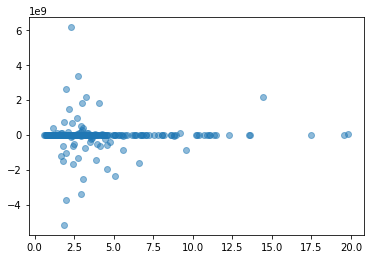

In [58]:
plt.scatter(valid_y, lr.predict(valid_x), alpha=0.5)

In [ ]:
groups = im_to_const.groupby(['clust_lat', 'clust_lon'])

In [ ]:
sub = groups.mean()[['nightlight', 'consumption']].reset_index(drop=True)

In [ ]:
sub.head()

In [ ]:
idea = LinearRegression()
n_train = int(0.8*(len(sub)))
inds = np.arange(len(sub))
train_ind = np.random.choice(inds, n_train, replace=False)
valid_ind = np.delete(inds, train_ind)

x = sub['nightlight'].values[train_ind].reshape(-1,1)
x_valid = sub['nightlight'].values[valid_ind].reshape(-1,1)

y_hat = sub['consumption'].values
y_hat[y_hat>20] = np.median(y_hat[y_hat<20])
y = y_hat[train_ind]
y_valid = y_hat[valid_ind]

idea.fit(x,y)

In [ ]:
idea.score(x,y)

In [ ]:
idea.score(x_valid,y_valid)

In [ ]:
plt.scatter(x,y, alpha=0.25)